## Open farm and run simple diagnostic


## Load packages

In [1]:
!pip install odc-ui rasterstats

  Using cached odc_ui-0.2.0a3-py3-none-any.whl (15 kB)
  Using cached rasterstats-0.19.0-py3-none-any.whl (16 kB)
  Using cached jupyter_ui_poll-0.2.2-py2.py3-none-any.whl (9.0 kB)
  Using cached simplejson-3.19.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (144 kB)


In [2]:
import time
start = time.time()

import warnings
warnings.filterwarnings('ignore')

In [3]:
%%time
from grits import get_field, get_lims, get_mms, query_l2a_items, xr_rasterize, calculate_indices

# the basic
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# for PC, stac, xarray
import stackstac
from xrspatial import zonal_stats

# From DEA
import sys
sys.path.append('/home/jovyan/PlanetaryComputerExamples/grasspace/deafrica-sandbox-notebooks/Tools/deafrica_tools/')
from plotting import display_map, rgb, map_shapefile

# packages that have to be installed every runtime
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

CPU times: user 3.4 s, sys: 1.03 s, total: 4.43 s
Wall time: 24 s


## Área de análise
Using function get_field for 

1. for fields in a farm - OK
2. for a group in a group of farms - OK
3. for specific fields in a farm - OK
4. ToDo - for an entire farm - the simplest case, as if the polygon was already given straight from a file

In [4]:
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'

# daterange analysis
datetime = "2016-08-10/2023-09-23"


#### Área: Fazenda Uniguiri
**Column parte** contém as regiões

#### Área: Iacanga - Cana

Grupo de talhoes dentro de todas fazendas de uma usina


got bbox, lat_range, lon_range
      AdMapKey           AREA                                 CENTER  \
1376      1377  220099.217447  675353.1865,7579203.6710,3032076.0000   
1377      1378  247886.776979  675029.2912,7579405.4888,3032079.0000   

      ELEVATION          LAYER                 TID  \
1376  3032076.0  032 APARECIDA  1377-032 APARECIDA   
1377  3032079.0  032 APARECIDA  1378-032 APARECIDA   

                                               geometry  
1376  MULTIPOLYGON Z (((-49.30302 -21.87880 3032076....  
1377  MULTIPOLYGON Z (((-49.30305 -21.87875 3032079....  
CPU times: user 2.31 s, sys: 147 ms, total: 2.45 s
Wall time: 2.35 s


<Axes: >

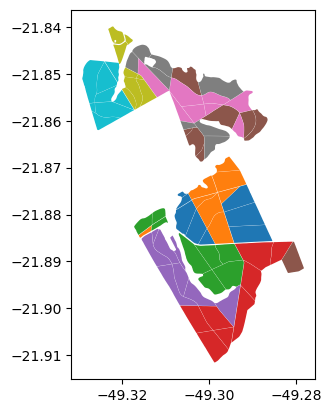

In [7]:
%%time

field = get_field(path + 'iacanga_22_23.gpkg',
                 column = 'LAYER',
                 ID = '032 APARECIDA',
                 layer = 'talhoes')

# field = gpd.read_file(path + 'iacanga_22_23.gpkg')
bbox, lat_range, lon_range = get_lims(field)

print(field.head(2))
field.plot(column = 'TID')

<Axes: >

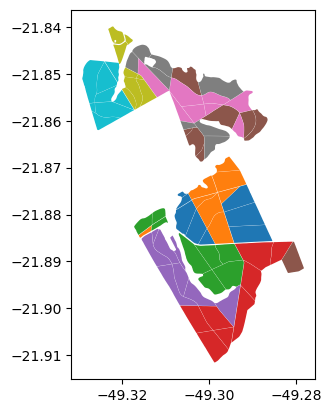

In [7]:
field['TID'] = field.TID.str.replace(" APARECIDA","")
field['TID'] = field.TID.str.replace("-","")
field.plot(column = 'TID')

### Display bbox study area
DREAM FUNCTION: sobrepor 'field'

In [ ]:
style={'opacity': 6, 'stroke': 2,'dashArray': '1', 'fillOpacity': 0.5}
map_shapefile(field,'parte',cmap='Set1', **style )

In [8]:
# Display from lat and lon range
display_map(x=lon_range, y=lat_range, zoom_bias = 0.3)

## Get images

### get Sentinel 2 L2A Data
colocar as especificidades aqui

In [9]:
%%time
items = query_l2a_items(bbox, datetime, 30)

 found 491 items
CPU times: user 1.14 s, sys: 77 ms, total: 1.22 s
Wall time: 5.39 s


In [10]:
# For Sentinel 2
data = (
    stackstac.stack(
        items,
        assets = ["B11","B12","B08","B06", "B04", "B03","B02", "SCL"],    #["B12","B11","B08","B08","B05","B04","B03","B02"],  
        chunksize=256,
        #resolution=0.0001, #0.0001
        epsg=4326,
        bounds=bbox,
        properties = True,
        fill_value = np.nan,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)

# fix xy names
data = data.rename({'x': 'longitude','y': 'latitude'})

data

<xarray.DataArray 'stackstac-d0d35d774b0210d07d9081738c24d15b' (time: 491,
                                                                band: 8,
                                                                latitude: 790,
                                                                longitude: 524)>
dask.array<where, shape=(491, 8, 790, 524), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2016-08-28...
    id                                       (time) <U54 'S2A_MSIL2A_20160828...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -49.33 ... -...
  * latitude                                 (latitude) float64 -21.84 ... -2...
    s2:degraded_msi_data_percentage          (time) float64 0.0 0.0 ... 0.0194
    ...                                       ...
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    proj:bbox                                object {600000.0, 7490200.0, 709...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-49.329259538282066, -21.91...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-49.33|\n| 0.00,-0.00,-21.84|\n| 0.00, 0.00,...
    resolution_xy:  (9.726740071158702e-05, 9.089970787456991e-05)

### Mask dataset com fazenda

In [11]:
%%time
#create mask versao dataarray
mask = xr_rasterize(field,data,
                    # x_dim='x',
                    # y_dim='y',
                   #export_tiff='masked2.tiff',
                   ) 

# #mask data
data = data.where(mask)

# #convert to float 32 to conserve memory
data = data.astype(np.float32)
data

CPU times: user 52 ms, sys: 3.97 ms, total: 56 ms
Wall time: 53.2 ms


<xarray.DataArray 'stackstac-d0d35d774b0210d07d9081738c24d15b' (time: 491,
                                                                band: 8,
                                                                latitude: 790,
                                                                longitude: 524)>
dask.array<astype, shape=(491, 8, 790, 524), dtype=float32, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2016-08-28...
    id                                       (time) <U54 'S2A_MSIL2A_20160828...
  * band                                     (band) object 'swir16' ... None
  * longitude                                (longitude) float64 -49.33 ... -...
  * latitude                                 (latitude) float64 -21.84 ... -2...
    s2:degraded_msi_data_percentage          (time) float64 0.0 0.0 ... 0.0194
    ...                                       ...
    title                                    (band) <U36 'Band 11 - SWIR (1.6...
    proj:bbox                                object {600000.0, 7490200.0, 709...
    common_name                              (band) object 'swir16' ... None
    center_wavelength                        (band) object 1.61 2.19 ... None
    full_width_half_max                      (band) object 0.143 0.242 ... None
    epsg                                     int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-49.329259538282066, -21.91...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-49.33|\n| 0.00,-0.00,-21.84|\n| 0.00, 0.00,...
    resolution_xy:  (9.726740071158702e-05, 9.089970787456991e-05)

In [12]:
# calcula indices
ds_ = data.to_dataset(dim='band')

# os indices
indices = ["LAI", "EVI","NDCI","BSI"]
ds = calculate_indices(ds_, 
                       index= indices, 
                       satellite_mission='s2', 
                       drop=True);

Dropping bands ['swir16', 'swir22', 'nir', 'rededge', 'red', 'green', 'blue', None]


In [13]:
%%time
ds.compute();

CPU times: user 6min 5s, sys: 1min 34s, total: 7min 39s
Wall time: 8min 14s


## Criar zonas

In [18]:
field = field[field['LAYER'] == '032 APARECIDA']

Rasterizing to match xarray.DataArray dimensions (790, 524)
CPU times: user 175 ms, sys: 15.2 ms, total: 190 ms
Wall time: 178 ms


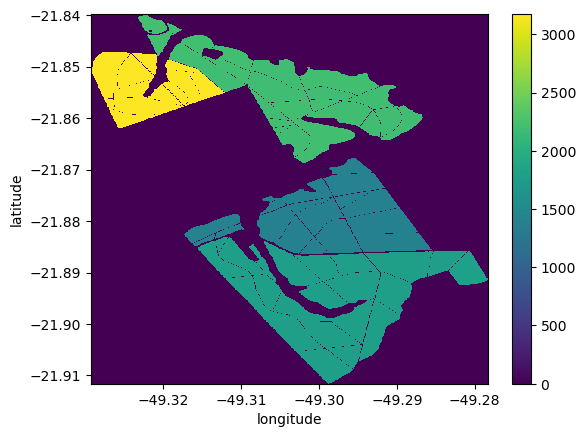

In [19]:
%%time
column = 'AdMapKey' # 'parte'
fm = xr_rasterize(field,data,attribute_col=column,verbose=True)
fm = fm.chunk(256)
fm.astype('uint8')
# fm_f64 = fm.astype('float64')
# fm_u8 = fm.astype('uint8')

fm.plot()

### Calculate stats for IVs dataset

#### single image

#### for a series

In [15]:
%%time
nameout = 'iacanga_'
verbose = False
for iv in indices:

    # get stats for the first dataframe
    data_ = ds[iv].sel(time=ds[iv].time.values[0]).squeeze()
    print('computing stats for the first date')
    outst = zonal_stats(zones=fm, values=data_).compute()
    outst['date'] = str(ds[iv].time.values[0])
    data_.close()

    # and through the loop
    for t in data.time.values[1:]:
        data_ = ds[iv].sel(time=t).squeeze()
        if verbose: print(f'computing stats for {t}')
        
        outst1 = zonal_stats(zones=fm, values=data_).compute()
        outst1['date'] = str(t)
        outst = pd.concat([outst,outst1])
        data_.close()
        del outst1

    outst.to_csv(f'/home/jovyan/PlanetaryComputerExamples/myout_csv/grasspace/{nameout}_{iv}.csv')
    print(f'{nameout}_{iv}.csv SAVED \n \n')
    del outst

computing stats for the first date


NameError: name 'fm' is not defined

### Calculare stats for single image

### Calculate stats for a series

In [ ]:
end = time.time()
print(f'{(end - start):.0f} seconds')